In [1]:
import torch

# Set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

Set up the MNIST dataset

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform to normalize and convert to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Define the VAE architecture

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=30):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 100),
            nn.ReLU(),
        )
        
        # Latent space
        self.fc_mu = nn.Linear(100, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(100, latent_dim)  # Log-variance
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()  # Outputs pixel values in [0, 1]
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std
    
    def forward(self, x):
        # Flatten input
        x = x.view(-1, 28*28)
        
        # Encode
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        
        # Sample from latent space
        z = self.reparameterize(mu, logvar)
        
        # Decode
        recon_x = self.decoder(z)
        recon_x = recon_x.view(-1, 1, 28, 28)  # Reshape to image dimensions
        return recon_x, mu, logvar

Define the loss function

The loss is a combination of:

Reconstruction Loss: Measures how well the output matches the input.
KL Divergence: Regularizes the latent space to follow a Gaussian distribution.

In [4]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') 
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

Train the VAE

In [5]:
import torch.optim as optim

# Initialize model, optimizer, and device
latent_dim = 30
vae = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
epochs = 50
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 50.1318
Epoch 2, Loss: 37.9978
Epoch 3, Loss: 34.4467
Epoch 4, Loss: 32.7289
Epoch 5, Loss: 31.6716
Epoch 6, Loss: 30.9219
Epoch 7, Loss: 30.4037
Epoch 8, Loss: 30.0204
Epoch 9, Loss: 29.7282
Epoch 10, Loss: 29.4719
Epoch 11, Loss: 29.2533
Epoch 12, Loss: 29.0966
Epoch 13, Loss: 28.9367
Epoch 14, Loss: 28.8064
Epoch 15, Loss: 28.6831
Epoch 16, Loss: 28.5544
Epoch 17, Loss: 28.4558
Epoch 18, Loss: 28.3448
Epoch 19, Loss: 28.2604
Epoch 20, Loss: 28.1831
Epoch 21, Loss: 28.1179
Epoch 22, Loss: 28.0642
Epoch 23, Loss: 27.9795
Epoch 24, Loss: 27.9440
Epoch 25, Loss: 27.8892
Epoch 26, Loss: 27.8416
Epoch 27, Loss: 27.7920
Epoch 28, Loss: 27.7476
Epoch 29, Loss: 27.6908
Epoch 30, Loss: 27.6751
Epoch 31, Loss: 27.6168
Epoch 32, Loss: 27.5798
Epoch 33, Loss: 27.5681
Epoch 34, Loss: 27.5383
Epoch 35, Loss: 27.4994
Epoch 36, Loss: 27.4654
Epoch 37, Loss: 27.4357
Epoch 38, Loss: 27.4302
Epoch 39, Loss: 27.3823
Epoch 40, Loss: 27.3535
Epoch 41, Loss: 27.3245
Epoch 42, Loss: 27.3063
E

Generate new images

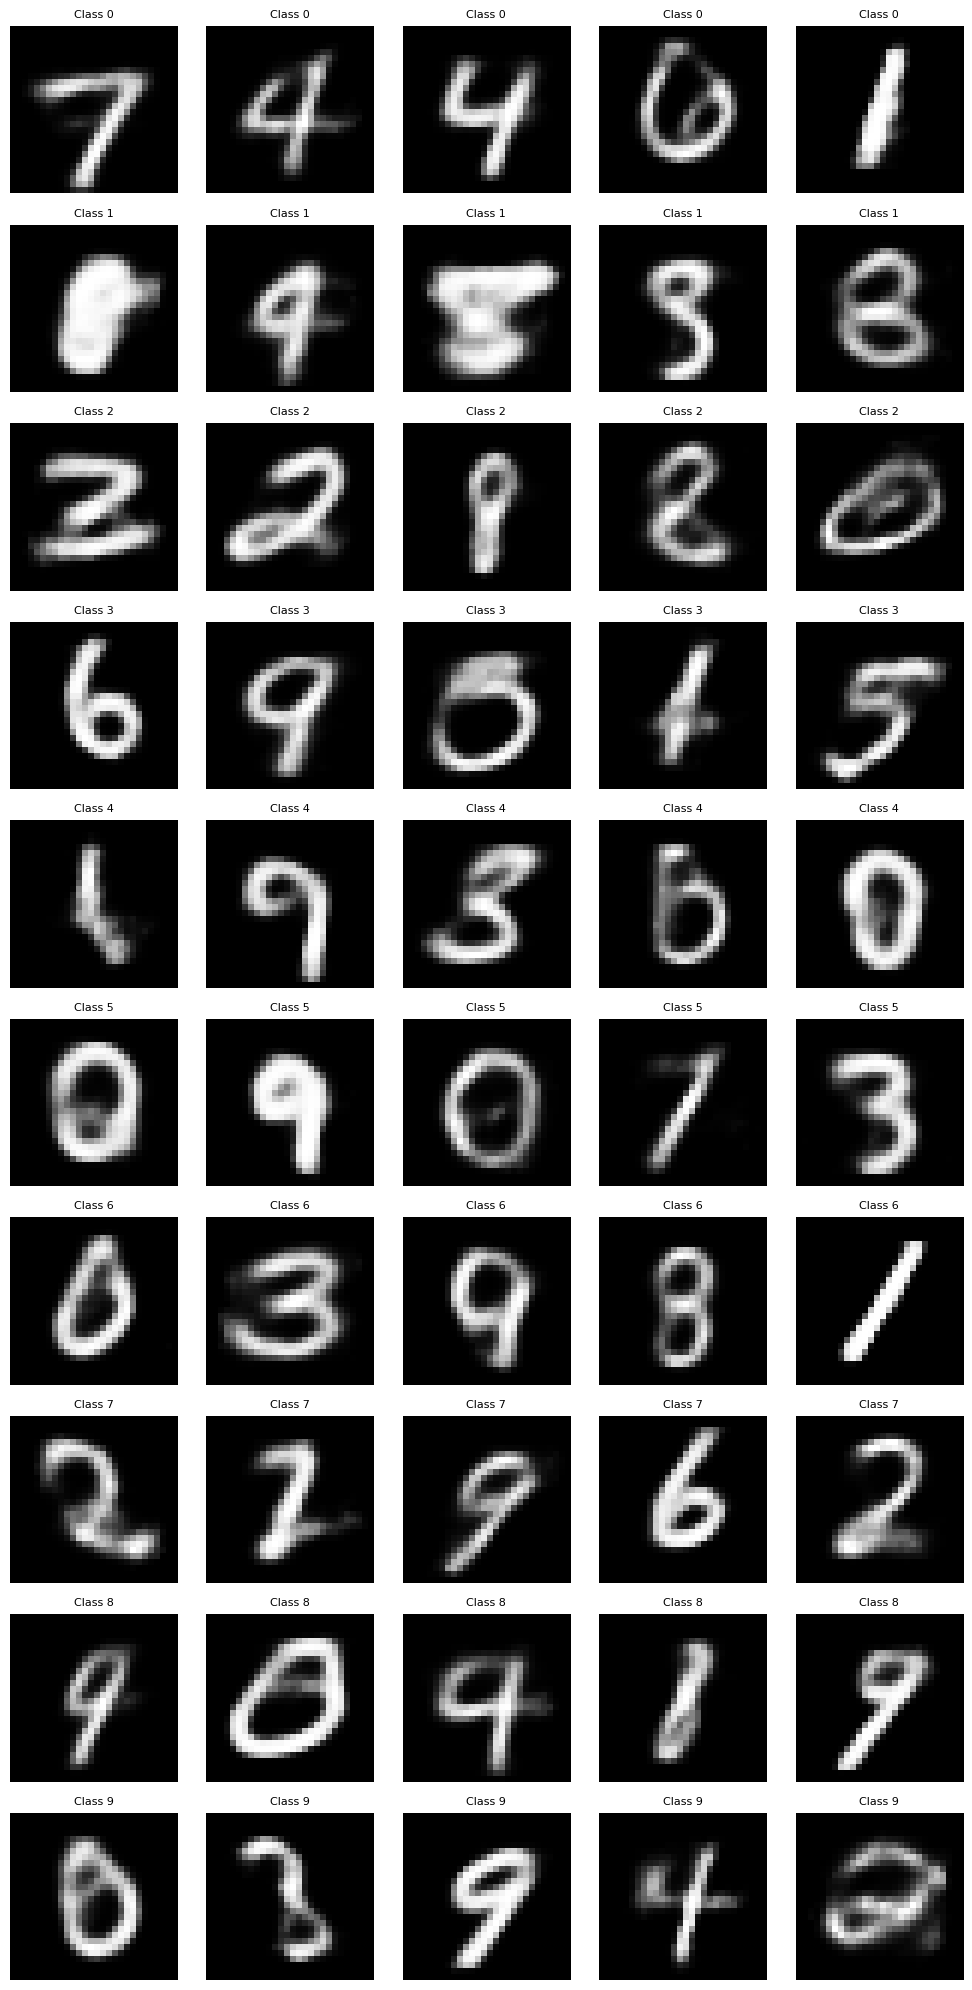

In [6]:
import matplotlib.pyplot as plt
import torch

# Function to generate 5 samples for each class
def generate_samples_per_class(vae, num_samples=5, latent_dim=30):
    vae.eval()
    generated_images = []

    # Loop through each class (0-9) and generate `num_samples` samples per class
    with torch.no_grad():
        for label in range(10):  # Class labels from 0 to 9
            class_samples = []
            for _ in range(num_samples):
                # Generate a random latent vector with class-specific bias
                z = torch.randn(1, latent_dim).to(device)
                generated_image = vae.decoder(z).view(1, 28, 28).cpu()

                # generated_image = vae.decoder(z).view(1, 28, 28).cpu()  # Decode latent vector
                class_samples.append(generated_image.squeeze())  # Remove channel dimension

            generated_images.append(class_samples)

    return generated_images

# Generate 5 sample images for each of the 10 classes
generated_images = generate_samples_per_class(vae, num_samples=5, latent_dim=latent_dim)

# Plot the generated images in an ordered manner
fig, axes = plt.subplots(10, 5, figsize=(10, 20))  # 10 rows for each class, 5 images per row
for i, class_samples in enumerate(generated_images):
    for j, sample in enumerate(class_samples):
        axes[i, j].imshow(sample, cmap='gray')
        axes[i, j].axis('off')  # Hide axes
        axes[i, j].set_title(f'Class {i}', fontsize=8)  # Add class label as title

# Add row labels for class numbers
for i, ax_row in enumerate(axes):
    ax_row[0].set_ylabel(f"Class {i}", rotation=0, labelpad=40, fontsize=12, va='center')

plt.tight_layout()
plt.show()

Generate interpolations

To generate images "in-between" two classes:

Encode two images (e.g., "1" and "3") into their latent vectors.
Linearly interpolate between the two latent vectors.
Decode the interpolated vectors.

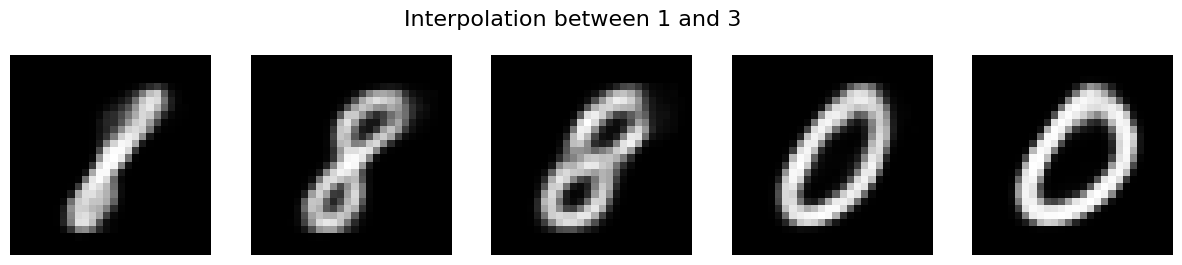

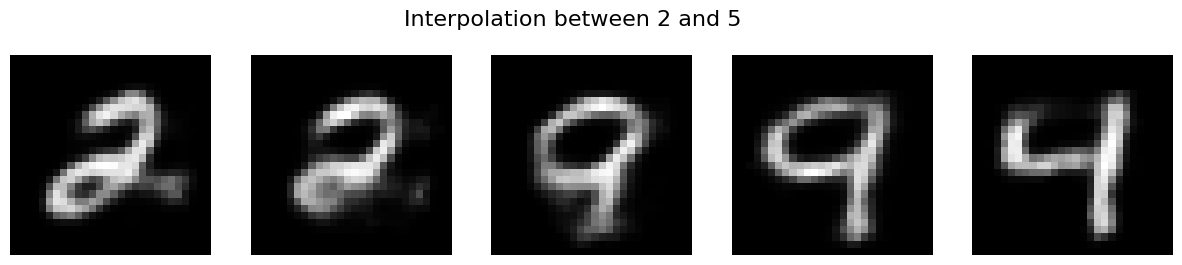

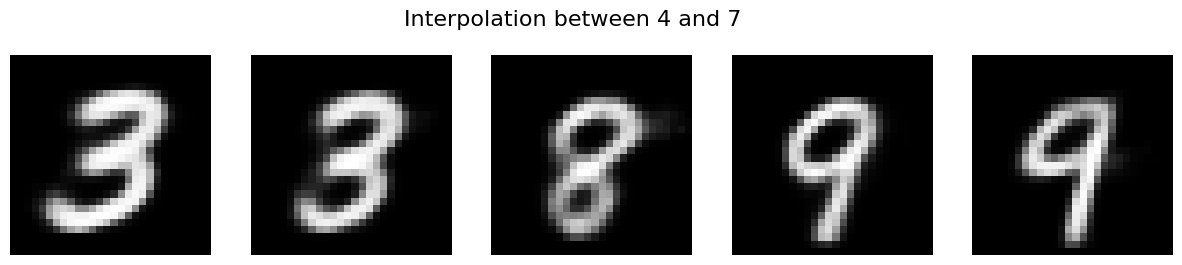

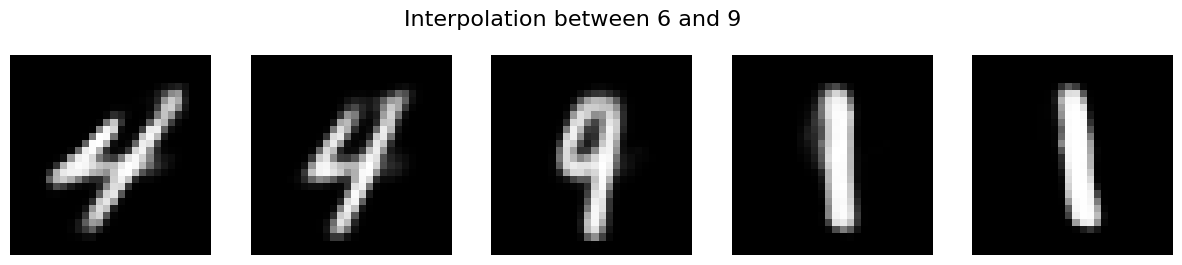

In [7]:
import torch
import matplotlib.pyplot as plt

# Encode an image to its latent vector using the VAE
def encode_to_latent(vae, img, device):
    hidden = vae.encoder(img.view(-1, 28 * 28))  # Flatten image
    mu = vae.fc_mu(hidden)
    logvar = vae.fc_logvar(hidden)
    z = vae.reparameterize(mu, logvar)
    return z

# Interpolate between two latent vectors
def interpolate_latent_vectors(z1, z2, steps=5):
    return torch.stack([alpha * z1 + (1 - alpha) * z2 for alpha in torch.linspace(0, 1, steps)])

# Decode latent vectors into images
def decode_latent_vectors(vae, latent_vectors, device):
    with torch.no_grad():
        decoded_images = vae.decoder(latent_vectors).view(-1, 1, 28, 28).cpu()
    return decoded_images

# Visualize a sequence of images
def visualize_images(images, title="Interpolation", cmap='gray'):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes):
        ax.imshow(images[i][0], cmap=cmap)
        ax.axis('off')
    plt.show()

# Perform interpolation between two images and visualize the result
def interpolate_images(vae, img1, img2, steps=5, device='cpu', title="Interpolation"):
    vae.eval()
    with torch.no_grad():
        # Encode images to latent space
        z1 = encode_to_latent(vae, img1.to(device), device)
        z2 = encode_to_latent(vae, img2.to(device), device)

        # Interpolate between latent vectors
        interpolations = interpolate_latent_vectors(z1, z2, steps).to(device)

        # Decode interpolations to images
        decoded_images = decode_latent_vectors(vae, interpolations, device)

        # Visualize results
        visualize_images(decoded_images, title=title)

# Repeat for pairs
for (i1, i2) in [(1, 3), (2, 5), (4, 7), (6, 9)]:
    img1, img2 = train_dataset[i1][0], train_dataset[i2][0]
    img1, img2 = img1.to(device), img2.to(device)
    interpolate_images(vae, img1, img2, steps=5, device=device, title=f"Interpolation between {i1} and {i2}")